In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(45)

In [2]:
body_fat_df = pd.read_csv('Lab-1-Zadanie-2-Dane.txt', sep="\t")

In [3]:
body_fat_df.head()

,Density,Pct.BF,Age,Weight,Height,Neck,Chest,Abdomen,Waist,Hip,Thigh,Knee,Ankle,Bicep,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,33.543307,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,32.677165,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,34.606299,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,34.015748,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,39.370079,101.9,63.2,42.2,24.0,32.2,27.7,17.7


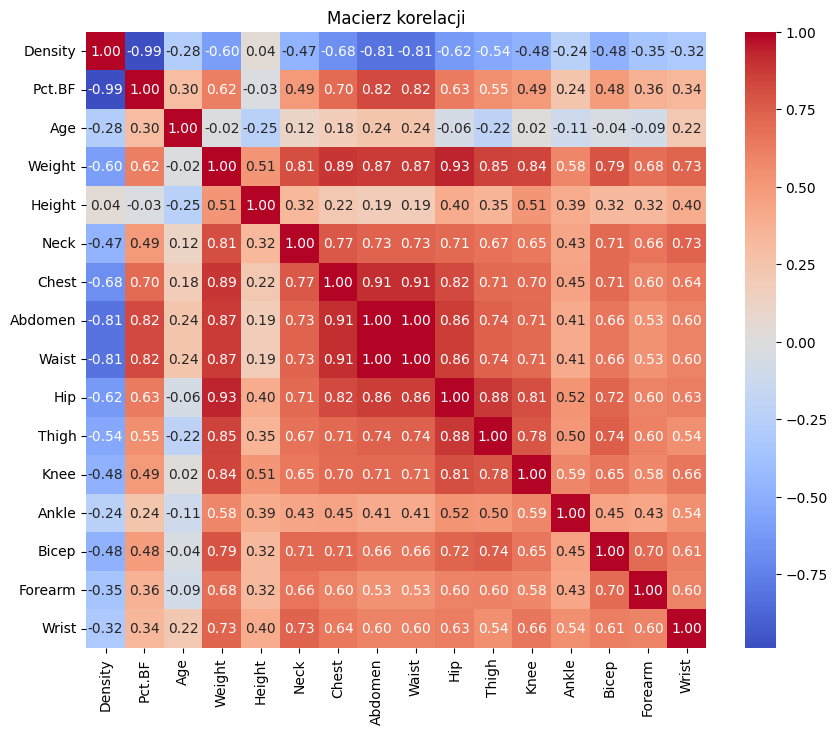

In [4]:
plt.figure(figsize=(10,8))
sns.heatmap(body_fat_df.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Macierz korelacji')
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
import statsmodels.api as sm
from sklearn.linear_model import LassoCV, Lasso, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler

In [5]:
def calculate_std(y_test, y_pred, df):
    sse = np.sum((y_test - y_pred) ** 2)
    df_total = len(y_test) - df - 1
    # print(len(y_test), df)
    return np.sqrt(sse / df_total)


def calculate_we(y_test, y_pred, df):
  return (calculate_std(y_test, y_pred, df) / np.mean(y_test)) * 100

# Najpierw bodyfat!

***STANDARYZACJA FIRST!!! BO MAMY RÓŻNE SKALE I WSPÓŁCZYNNIKI NIEPROPORCJONALNE KARY BY DOSTAWAŁY. Bez standaryzacji zmienne o dużych skalach otrzymywałyby nieproporcjonalnie dużą karę w porównaniu do zmiennych o mniejszych skalach.***

In [31]:
X = body_fat_df.drop(['Pct.BF'], axis=1) # zostawiam density, zgodnie z tym co Pan Profesor mówił na labach :)
y = body_fat_df['Pct.BF']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # ucze sie treningowych (liczy srednia, odchylenie, zeby ustandaryzowac) i przeskalowuje
X_test_scaled = scaler.transform(X_test) # przeskalowuje tylko

**LASSO poraz 2 ;)**

In [55]:
lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_train_scaled, y_train)

lasso_feats = X_train.columns[lasso_cv.coef_ != 0].tolist()
print("LASSO wybrał:", lasso_feats)

X_train_lasso = sm.add_constant(X_train[lasso_feats])
X_test_lasso = sm.add_constant(X_test[lasso_feats])

model_lasso = sm.OLS(y_train, X_train_lasso).fit()

y_pred = model_lasso.predict(X_test_lasso)
we = calculate_we(y_test, y_pred, model_lasso.df_model)

print(f"Współczynnik zmienności We: {we}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred)}")
print(model_lasso.summary())


LASSO wybrał: ['Density', 'Age', 'Abdomen', 'Waist']
Współczynnik zmienności We: 8.692256701472736
MSE: 1.978162529432811
MAE: 0.6252310709925368
RMSE: 1.406471659662153
MAPE: 0.06394165917056986
                            OLS Regression Results                            
Dep. Variable:                 Pct.BF   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     2078.
Date:                Sat, 24 Jan 2026   Prob (F-statistic):          1.26e-158
Time:                        10:59:09   Log-Likelihood:                -322.06
No. Observations:                 200   AIC:                             654.1
Df Residuals:                     195   BIC:                             670.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
              

**Można było się tego spodziewać, że zostanie, m.in. Density, Abdomen i Waist, bo one są silnie skorelowane z bodyfatem, na podstawie macierzy korelacji + Age tez ma korelacje z bodyfatem, ale nie tak silną jak te wspomniane wyżej + o wiele lepsze dopasowanie na podstawie We poronujac je z wartoscia z pierwotnego sprawozdania naszego**

**Ridge poraz 1 ;)**

In [46]:
ridge_cv = RidgeCV(cv=5)
ridge_cv.fit(X_train_scaled, y_train)

# ridge_feats = X_train.columns[ridge_cv.coef_ != 0].tolist()
# print("RIDGE wybrał:", ridge_feats)

# tu się zaczyna ciekawie, bo wszystkie są !=0, więc posortuje je rosnaco i dokonam selekcji top 5 np.
coefs = pd.Series(ridge_cv.coef_, index=X_train.columns)
ridge_significance = coefs.abs().sort_values(ascending=False) # interesuje na "siła zależności"

ridge_significance.head(5)
# print(coefs.loc[ridge_significance.index])

,0
Density,7.371225
Weight,0.451206
Ankle,0.365994
Waist,0.233807
Abdomen,0.233807


In [47]:
ridge_feats = ridge_significance.index.tolist()[:5]
ridge_feats

['Density', 'Weight', 'Ankle', 'Waist', 'Abdomen']

In [48]:
X_train_ridge = sm.add_constant(X_train[ridge_feats])
X_test_ridge = sm.add_constant(X_test[ridge_feats])

model_ridge = sm.OLS(y_train, X_train_ridge).fit()
y_pred = model_ridge.predict(X_test_ridge)
we = calculate_we(y_test, y_pred, model_ridge.df_model)

print(f"Współczynnik zmienności We: {we}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred)}")
print(model_ridge.summary())

Współczynnik zmienności We: 9.484778826116912
MSE: 2.302986875961301
MAE: 0.7208103246749001
RMSE: 1.517559513153043
MAPE: 0.06909127115801433
                            OLS Regression Results                            
Dep. Variable:                 Pct.BF   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1685.
Date:                Sat, 24 Jan 2026   Prob (F-statistic):          1.06e-157
Time:                        10:38:53   Log-Likelihood:                -320.24
No. Observations:                 200   AIC:                             652.5
Df Residuals:                     194   BIC:                             672.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025 

**Again, można było się spodziewać, że zostaną, m.in. Density, Waist i Abdomen ze względu na silną korelację, troche wyzsze We od Lasso, ale bardzo dobre dopasowanie pokazuje, bo jest lepsze od tego z pierwotnego sprawozdania + te inne zmienne tez maja korelacje z bodyfatem, ale nie tak silną jak te 3 wspomniane wyżej**

**Elastic Net poraz 1 ;)**

In [58]:
elastic_net_cv = ElasticNetCV(cv=5, l1_ratio=[.1, .5, .7, .9, .95, .99, .5])
elastic_net_cv.fit(X_train_scaled, y_train)

elastic_feats = X_train.columns[elastic_net_cv.coef_ != 0].tolist()
print("ELEASTIC NET wybrał:", elastic_feats)

X_train_elastic = sm.add_constant(X_train[elastic_feats])
X_test_elastic = sm.add_constant(X_test[elastic_feats])

model_elastic_net = sm.OLS(y_train, X_train_elastic).fit()

y_pred = model_elastic_net.predict(X_test_elastic)
we = calculate_we(y_test, y_pred, model_elastic_net.df_model)

print(f"Współczynnik zmienności We: {we}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred)}")
print(model_elastic_net.summary())



ELEASTIC NET wybrał: ['Density', 'Age', 'Abdomen', 'Waist']
Współczynnik zmienności We: 8.692256701472736
MSE: 1.978162529432811
MAE: 0.6252310709925368
RMSE: 1.406471659662153
MAPE: 0.06394165917056986
                            OLS Regression Results                            
Dep. Variable:                 Pct.BF   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     2078.
Date:                Sat, 24 Jan 2026   Prob (F-statistic):          1.26e-158
Time:                        11:05:19   Log-Likelihood:                -322.06
No. Observations:                 200   AIC:                             654.1
Df Residuals:                     195   BIC:                             670.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
       

**Dostalismy ten sam wynik de facto jak dla czystego Lasso, co dowodzi ze jest on dobrym modelem, jest to potwierdzenie dla nas de facto, bo nawet wartosci bledow obliczonych sa mniejsze!!!**

# Potem density!!

In [59]:
X = body_fat_df.drop(['Density'], axis=1)
y = body_fat_df['Density']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

In [60]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # ucze sie treningowych (liczy srednia, odchylenie, zeby ustandaryzowac) i przeskalowuje
X_test_scaled = scaler.transform(X_test) # przeskalowuje tylko

**Lasso**

In [61]:
lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_train_scaled, y_train)

lasso_feats = X_train.columns[lasso_cv.coef_ != 0].tolist()
print("LASSO wybrał:", lasso_feats)

X_train_lasso = sm.add_constant(X_train[lasso_feats])
X_test_lasso = sm.add_constant(X_test[lasso_feats])

model_lasso = sm.OLS(y_train, X_train_lasso).fit()

y_pred = model_lasso.predict(X_test_lasso)
we = calculate_we(y_test, y_pred, model_lasso.df_model)

print(f"Współczynnik zmienności We: {we}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred)}")
print(model_lasso.summary())

LASSO wybrał: ['Pct.BF', 'Height']
Współczynnik zmienności We: 0.3176962228831863
MSE: 1.0659153464323166e-05
MAE: 0.0012079694426421074
RMSE: 0.003264835901591865
MAPE: 0.001141301183384315
                            OLS Regression Results                            
Dep. Variable:                Density   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     3873.
Date:                Sat, 24 Jan 2026   Prob (F-statistic):          7.12e-159
Time:                        11:23:10   Log-Likelihood:                 885.62
No. Observations:                 200   AIC:                            -1765.
Df Residuals:                     197   BIC:                            -1755.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 co

**Ridge**

In [62]:
ridge_cv = RidgeCV(cv=5)
ridge_cv.fit(X_train_scaled, y_train)

# ridge_feats = X_train.columns[ridge_cv.coef_ != 0].tolist()
# print("RIDGE wybrał:", ridge_feats)

# tu się zaczyna ciekawie, bo wszystkie są !=0, więc posortuje je rosnaco i dokonam selekcji top 5 np.
coefs = pd.Series(ridge_cv.coef_, index=X_train.columns)
ridge_significance = coefs.abs().sort_values(ascending=False) # interesuje na "siła zależności"

ridge_significance.head(5)
# print(coefs.loc[ridge_significance.index])

,0
Pct.BF,0.017619
Weight,0.001111
Ankle,0.000941
Wrist,0.000794
Abdomen,0.000706


In [63]:
ridge_feats = ridge_significance.index.tolist()[:5]
ridge_feats

['Pct.BF', 'Weight', 'Ankle', 'Wrist', 'Abdomen']

In [64]:
X_train_ridge = sm.add_constant(X_train[ridge_feats])
X_test_ridge = sm.add_constant(X_test[ridge_feats])

model_ridge = sm.OLS(y_train, X_train_ridge).fit()
y_pred = model_ridge.predict(X_test_ridge)
we = calculate_we(y_test, y_pred, model_ridge.df_model)

print(f"Współczynnik zmienności We: {we}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred)}")
print(model_ridge.summary())

Współczynnik zmienności We: 0.3581673333346173
MSE: 1.2683098855786501e-05
MAE: 0.0016193545268893717
RMSE: 0.0035613338590739425
MAPE: 0.0015325678646046044
                            OLS Regression Results                            
Dep. Variable:                Density   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1598.
Date:                Sat, 24 Jan 2026   Prob (F-statistic):          1.59e-155
Time:                        11:24:31   Log-Likelihood:                 890.15
No. Observations:                 200   AIC:                            -1768.
Df Residuals:                     194   BIC:                            -1749.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|

istotnosc abdomen ? pct bodyfat zaburza ?

**Elastic Net**

In [65]:
elastic_net_cv = ElasticNetCV(cv=5, l1_ratio=[.1, .5, .7, .9, .95, .99, .5])
elastic_net_cv.fit(X_train_scaled, y_train)

elastic_feats = X_train.columns[elastic_net_cv.coef_ != 0].tolist()
print("ELEASTIC NET wybrał:", elastic_feats)

X_train_elastic = sm.add_constant(X_train[elastic_feats])
X_test_elastic = sm.add_constant(X_test[elastic_feats])

model_elastic_net = sm.OLS(y_train, X_train_elastic).fit()

y_pred = model_elastic_net.predict(X_test_elastic)
we = calculate_we(y_test, y_pred, model_elastic_net.df_model)

print(f"Współczynnik zmienności We: {we}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred)}")
print(model_elastic_net.summary())

ELEASTIC NET wybrał: ['Pct.BF', 'Height']
Współczynnik zmienności We: 0.3176962228831863
MSE: 1.0659153464323166e-05
MAE: 0.0012079694426421074
RMSE: 0.003264835901591865
MAPE: 0.001141301183384315
                            OLS Regression Results                            
Dep. Variable:                Density   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     3873.
Date:                Sat, 24 Jan 2026   Prob (F-statistic):          7.12e-159
Time:                        11:25:05   Log-Likelihood:                 885.62
No. Observations:                 200   AIC:                            -1765.
Df Residuals:                     197   BIC:                            -1755.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
            

**Generalnie to te modele są o wiele gorsze jesli pod uwage wezmiemy tylko We, bo przekracza ona poziom bardzo dobrego dopasowania modelu do danych (>25%, ale < 45%, co oznacza przecietna zmiennosc). Wspolczynnik determinacji mowi o bardzo dobrym dopasownaiu modelu do danych, ale jest od jednak troche mniejszy niz te w modelach przewidujacych bodyfat. Model oparty o regularyzacje jest jednak troche lepszy, ma mniejsze wartosci bledow, co potrwierrdzil tez elastic net, bo dostalismy de facto ten sam model co w czystym lasso. W modelach jest m.in. zmienna pct bodyfat, czego mozna bylo sie spodziewaqc ze wzgledu na silna korelacje jej z density, na podstawie macierzy korelacji. Zmienna height w modelu z lasso nie ma duzej korelacji z density, wiec mozna przypuiszcacm, ze bodyfat ma najwiekszy wplyw na nia. Natonmiast w modxelu z ridge, mozna bylo sie spodziewac, ze oprocz pct bodyfat pojawia sie zmienne tez abdomen, gdyz jest ona silnie skorelowana ze zmeinna objasniana, pozostale zmienne tez maja korelacje z density, aczkolwiek jest ona mniejsza niz ta miedzy abdomen a density**